In [1]:
%pip install  langchain langgraph langchain_community langchain_huggingface chromadb transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 4.6 MB/s eta 0:00:00

In [9]:
from pydantic import BaseModel
from typing import List, Optional

class UserProfile(BaseModel):
    name: str
    age: int
    gender: str
    financial_status: str
    education: str
    mental_issues_reported: List[str]
    generation: str
    initial_mental_health_state: str

class TherapyEvaluation(BaseModel):
    generation_summary: str
    session_engagement: str
    emotional_tone: str
    strengths: List[str]
    areas_to_work_on: List[str]
    overall_feedback: str

class MentalHealthState(BaseModel):
    user_profile: UserProfile
    current_question: int = 0
    responses: List[str] = []
    evaluation_report: Optional[TherapyEvaluation] = None
    session_active: bool = True
    session_completed: bool = False
    session_feedback: Optional[str] = None
    session_summary: Optional[str] = None
    # session_engagement: Optional[str] = None
    # emotional_tone: Optional[str] = None
    # strengths: Optional[List[str]] = None
    # areas_to_work_on: Optional[List[str]] = None
    # overall_feedback: Optional[str] = None
    # generation_summary: Optional[str] = None
    # session_engagement: Optional[str] = None

In [10]:
from langgraph.graph import StateGraph, END
# from schemas import MentalHealthState, UserProfile, TherapyEvaluation
from langchain_core.messages import HumanMessage
from typing import Dict, Any
# from langchain.chat_models import ChatOpenAI
from langchain_huggingface import HuggingFaceEndpoint
from langchain_core.prompts import PromptTemplate
from langchain_core.prompts import ChatPromptTemplate

# llm = ChatOpenAI(model="gpt-4", temperature=0.7)

llm= HuggingFaceEndpoint(
    repo_id="meta-llama/Llama-3.2-3B-Instruct",
    task="text_generation",
    max_new_tokens=512,
    temperature=0.3,
    streaming=True,
    )

#Defining nodes for the workflow

# Node 1: Classify user
def classify_user_node(state: MentalHealthState) -> MentalHealthState:
    print(f"[CLASSIFY] User: {state.user_profile.name}")
    return state

# Node 2: Ask questions (simulated answers for now)

def therapy_session_node(state: MentalHealthState) -> MentalHealthState:
    # Generate 10 personalized therapy questions based on profile
    prompt = f"""
You are a mental health therapist.
Your task is to generate 10 personalized therapy questions for a client, based on their profile below.

Client Profile:
{state.user_profile.json(indent=2)}

Please keep the questions empathetic, open-ended, and focused on exploring emotions, habits, and thought patterns.

Respond with a numbered list of 10 therapy questions only.
"""

    result = llm([HumanMessage(content=prompt)])
    questions = result.content.strip().split("\n")

    # Simulate answers to each question (later you can replace this with speech-to-text)
    simulated_answers = [f"My answer to: {q}" for q in questions if q.strip()]

    state.responses = simulated_answers
    state.current_question = len(simulated_answers)
    return state


# Node 3: evaluate_session_node (simulated answers for now)

def evaluate_session_node(state: MentalHealthState) -> MentalHealthState:
    prompt = f"""
User Profile:
{state.user_profile.json(indent=2)}

Therapy Responses:
{state.responses}

Based on the profile and answers, generate a detailed session report with:
- generation_summary
- session_engagement
- emotional_tone
- strengths
- areas_to_work_on
- overall_feedback
Format the result as a JSON object.
"""
    result = llm([HumanMessage(content=prompt)])
    import json
    data = json.loads(result.content)
    state.evaluation_report = TherapyEvaluation(**data)
    return state




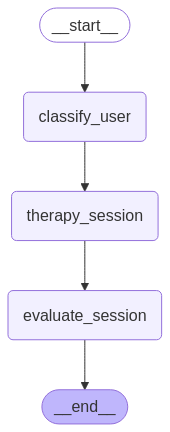

In [14]:
# Build the LangGraph

graph = StateGraph(MentalHealthState)
graph.add_node("classify_user", classify_user_node)
graph.add_node("therapy_session", therapy_session_node)
graph.add_node("evaluate_session", evaluate_session_node)
graph.set_entry_point("classify_user")
graph.add_edge("classify_user", "therapy_session")
graph.add_edge("therapy_session", "evaluate_session")
graph.set_finish_point("evaluate_session")
graph.compile()

# # Wrapper agent
# class MentalHealthAgent:
#     def __init__(self):
#         self.graph = build_mental_health_graph()

#     def run(self, query_id: str, user_id: str, state: MentalHealthState) -> Dict[str, Any]:
#         final_state = self.graph.invoke(state)
#         return {
#             "user_profile": final_state.user_profile,
#             "generation": final_state.user_profile.generation,
#             "initial_mental_health_state": final_state.user_profile.initial_mental_health_state,
#             "evaluation_report": final_state.evaluation_report.dict()
#         }